<a href="https://colab.research.google.com/github/Motz224/DCGAN_Anime_Face_20230828/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#%cd /content/drive/Shareddrives/Projects/DCGAN/Anime_Face_20230827

In [ ]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

import pandas as pd

In [ ]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs
# To get dataset
! pip install -q kaggle

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-y52r5msa
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-y52r5msa
  Resolved https://github.com/tensorflow/docs to commit e4ab8e01220062d0351ff63bd98486c6a82be2b5
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.7.13.64986-py3-none-any.whl size=184124 sha256=0626e7450953794721d67490563634a921e1a4dbc1c24d8e90d6f87c88243ab6
  Stored in directory: /tmp/pip-ephem-wheel-cache-e7qsn58m/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [ ]:
# upload kaggle.json
#from google.colab import files
#files.upload()

In [ ]:
#load files
def restore_files():
  !cp -r drive/Shareddrives/Projects/DCGAN/Anime_Face_AutoSave/images ./
  !cp -r drive/Shareddrives/Projects/DCGAN/Anime_Face_AutoSave/training_checkpoints ./
  !cp -r drive/Shareddrives/Projects/DCGAN/Anime_Face_AutoSave/epoch_num.txt ./
  !cp -r drive/Shareddrives/Projects/DCGAN/Anime_Face_AutoSave/kaggle.json ./
  !cp -r drive/Shareddrives/Projects/DCGAN/Anime_Face_AutoSave/training_loss_record.csv ./

In [ ]:
#initialize of epoch recording file
def initialize_epoch_num():
  f = open("epoch_num.txt", "w")
  f.write("0")
  f.close()

In [ ]:
initialize_epoch_num()

In [ ]:
restore_files()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#! kaggle datasets list

In [ ]:
# download the dataset
!kaggle datasets download -d prasoonkottarathil/gananime-lite
    #!kaggle datasets download -d lukexng/animefaces-512x512

100% 8.72G/8.73G [01:50<00:00, 135MB/s]
100% 8.73G/8.73G [01:50<00:00, 84.6MB/s]


In [ ]:
# make a folder and unzip the dataset
! mkdir ds
! unzip gananime-lite.zip -d ds

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: ds/out2/seed28784.png   
  inflating: ds/out2/seed28785.png   
  inflating: ds/out2/seed28786.png   
  inflating: ds/out2/seed28787.png   
  inflating: ds/out2/seed28788.png   
  inflating: ds/out2/seed28789.png   
  inflating: ds/out2/seed2879.png    
  inflating: ds/out2/seed28790.png   
  inflating: ds/out2/seed28791.png   
  inflating: ds/out2/seed28792.png   
  inflating: ds/out2/seed28793.png   
  inflating: ds/out2/seed28794.png   
  inflating: ds/out2/seed28795.png   
  inflating: ds/out2/seed28796.png   
  inflating: ds/out2/seed28797.png   
  inflating: ds/out2/seed28798.png   
  inflating: ds/out2/seed28799.png   
  inflating: ds/out2/seed2880.png    
  inflating: ds/out2/seed28800.png   
  inflating: ds/out2/seed28801.png   
  inflating: ds/out2/seed28802.png   
  inflating: ds/out2/seed28803.png   
  inflating: ds/out2/seed28804.png   
  inflating: ds/out2/seed28805.png   
  inflating: ds/out2/seed28806.png   
  inflating: ds/out2/se

In [ ]:
#base_dir = os.path.join(os.getcwd(), 'train/anime_face')
base_dir = 'ds/out2'
base_dir

'ds/out2'

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 16
IMAGE_SIZE = 96

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  labels=None,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE,
  )

Found 25663 files belonging to 1 classes.


In [ ]:
train_dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None)>

In [ ]:
def preprocess(image_batch):
  image_batch = tf.cast(image_batch, tf.float32)
  image_batch = image_batch / 127.5 - 1
  return image_batch

train_dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None)>

In [ ]:
train_dataset = train_dataset.map(preprocess).prefetch(tf.data.AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None)>

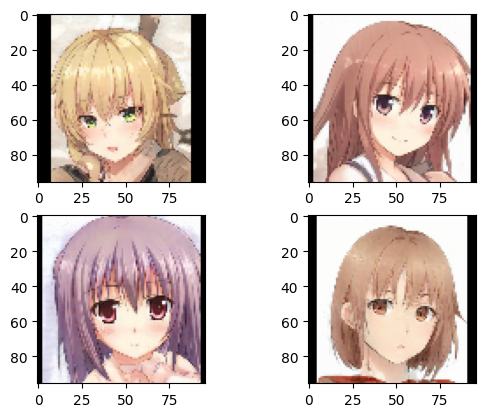

In [ ]:
# Visualize images from dataset
for batch in train_dataset:
    for i in range(4):
        plt.subplot(2, 2, i+1)
        #plt.imshow(batch.numpy()[i])
        plt.imshow(((batch.numpy() + 1) / 2)[i])  # get in the range [0, 1] for visualizing
    break
#plt.show()

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(3*3*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Reshape((6, 6, 256)))
    assert model.output_shape == (None, 6, 6, 256)  # Note: None is the batch size
    model.add(layers.Dropout(0.1))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 12, 12, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.1))

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 24, 24, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.1))

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 48, 48, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.1))

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 96, 96, 3)

    return model

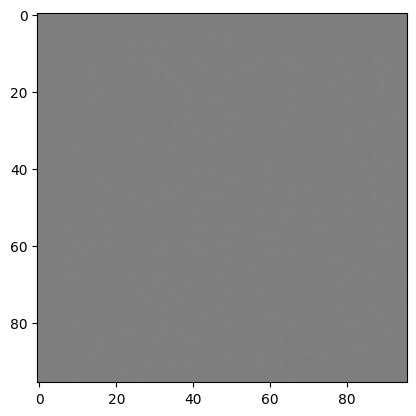

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow((generated_image[0]+1)/2)

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=[96, 96, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    #model.add(layers.LeakyReLU())

    #model.add(layers.sigmoid())

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-2.9505041e-05]], shape=(1, 1), dtype=float32)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
def save_loss(epoch,train_flag):
  noise = tf.random.normal([1, 100])
  generated_image = generator(noise, training=False)
  for batch in train_dataset:
    for i in range(1):
      real_op = discriminator(batch, training=False)
    break

  fake_op = discriminator(generated_image, training=False)

  D_Loss = discriminator_loss(real_op,fake_op)
  G_Loss = generator_loss(fake_op)

  #change it to element
  fake_op = fake_op.numpy().item(0,0)
  data = {
      "Epoch": epoch,
      "Discriminator_Real_Img_Dicision": real_op,
      "Discriminator_Fake_Img_Dicision": fake_op,
      "Discriminator_Loss": D_Loss.numpy().astype(float),
      "Generator_Loss": G_Loss.numpy().astype(float)
  }

  writeCSV(data,epoch,train_flag)

In [ ]:
def writeCSV(dict_data,epoch,train_flag):
  #switch open file
  import csv
  csv_columns = ["Epoch", "Discriminator_Real_Img_Dicision", "Discriminator_Fake_Img_Dicision", "Discriminator_Loss", "Generator_Loss"]
  if train_flag == True:
    csv_file = "training_loss_record.csv"
  else:
    csv_file = "validation_loss_record.csv"

  #write
  try:
    with open(csv_file, 'a+') as csvfile:
      writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
      # write header if file is first create
      if epoch == 1:
        writer.writeheader()
      #for data in dict_data:
      writer.writerow(dict_data)
  except IOError:
    print("I/O error")

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs,train_flag):

  current_epoch_num = find_epoch_num()

  for epoch in range(epochs):
    # change the epoch
    epoch = current_epoch_num + epoch

    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,epoch + 1,seed)

    # Save the model every epoch
    checkpoint_prefix = os.path.join(checkpoint_dir, "epoch-{}.ckpt".format(epoch+1))
    checkpoint.save(file_prefix = checkpoint_prefix)

    # save losses and epoch num every epoch
    save_loss(epoch+1,train_flag)
    update_epoch_num(epoch+1)

    # auto save all files to drive every 5 epoch
    if (epoch + 1) % 5 == 0:
      autosave_files()

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,epochs,seed)


In [ ]:
#checkpoint_dir = './training_checkpoints'
#checkpoint_prefix = os.path.join(checkpoint_dir, "epoch-{}.ckpt".format(epoch+1))

#checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
#                                 discriminator_optimizer=discriminator_optimizer,
#                                 generator=generator,
#                                 discriminator=discriminator)

In [ ]:
checkpoint_dir = './training_checkpoints'

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
#find current epoch
def find_epoch_num():
  f = open("epoch_num.txt", "r")
  epoch = int(f.read())
  f.close()
  return epoch

def update_epoch_num(epoch):
  f = open("epoch_num.txt", "w")

  f.write(str(epoch))
  f.close

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow((predictions[i]+1)/2)
      #plt.imshow(predictions[i, :, :, :] * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('images/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


In [ ]:
#auto save files to drive
def autosave_files():
  #!mkdir drive/Shareddrives/Projects/DCGAN/Anime_Face_AutoSave

  !cp -r images drive/Shareddrives/Projects/DCGAN/Anime_Face_AutoSave
  !cp -r training_checkpoints drive/Shareddrives/Projects/DCGAN/Anime_Face_AutoSave
  !cp -r epoch_num.txt drive/Shareddrives/Projects/DCGAN/Anime_Face_AutoSave
  !cp -r kaggle.json drive/Shareddrives/Projects/DCGAN/Anime_Face_AutoSave
  !cp -r training_loss_record.csv drive/Shareddrives/Projects/DCGAN/Anime_Face_AutoSave

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
train_flag = True

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
!mkdir drive/Shareddrives/Projects/DCGAN/Anime_Face_AutoSave

mkdir: cannot create directory ‘drive/Shareddrives/Projects/DCGAN/Anime_Face_AutoSave’: File exists


In [ ]:
train(train_dataset, EPOCHS, train_flag)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-51-d6b900899fbd>", line 1, in <cell line: 1>
    train(train_dataset, EPOCHS, train_flag)
  File "<ipython-input-32-f1c33e6acd97>", line 12, in train
    train_step(image_batch)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 894, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 926, in _call
    return self._no_variable_creation_fn(*args, **kwds)  # pylint: disable=not-callable
  File "/usr/local/lib/python3.10/dist-packages/

TypeError: ignored

In [ ]:
autosave_files()

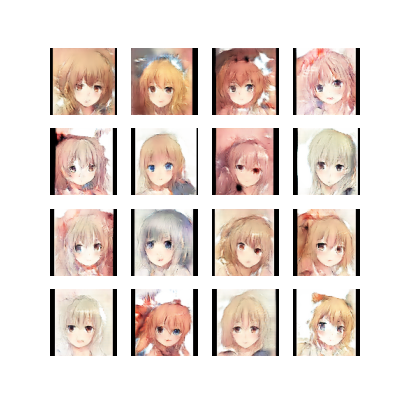

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('images/image_at_epoch_{:04d}.png'.format(epoch_no))
display_image(find_epoch_num())

In [ ]:
#make gif
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('images/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


<ipython-input-44-741e0b1c29ee>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-44-741e0b1c29ee>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

# save gif file to drive
!cp -r dcgan.gif drive/Shareddrives/Projects/DCGAN/Anime_Face_AutoSave

In [ ]:
for batch in train_dataset:
    for i in range(1):
      real_op = discriminator(batch, training=False)
    break
fake_op = discriminator(generated_image)
print("Discriminator_Dicision:", fake_op)
print("Discriminator_Loss:", discriminator_loss(real_op,fake_op))
print("Generator_Loss:", generator_loss(fake_op))

Discriminator_Dicision: tf.Tensor([[-6.5221376]], shape=(1, 1), dtype=float32)
Discriminator_Loss: tf.Tensor(0.95791584, shape=(), dtype=float32)
Generator_Loss: tf.Tensor(6.5236073, shape=(), dtype=float32)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 5 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Epoch                            300 non-null    int64  
 1   Discriminator_Real_Img_Dicision  300 non-null    object 
 2   Discriminator_Fake_Img_Dicision  300 non-null    float64
 3   Discriminator_Loss               300 non-null    float64
 4   Generator_Loss                   300 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 11.8+ KB


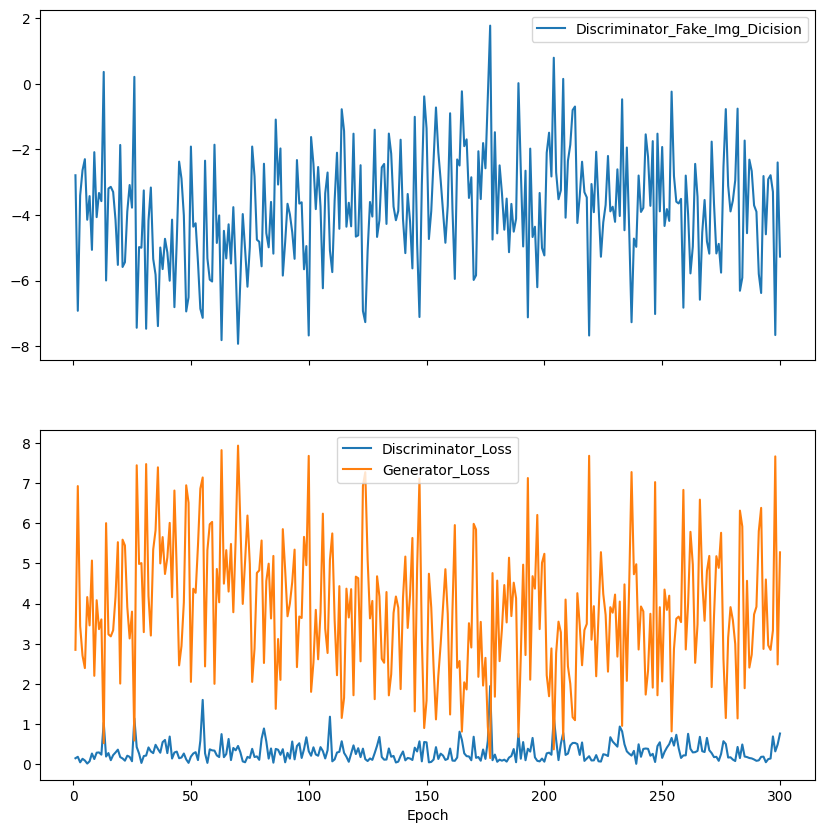

In [ ]:
#show loss record
training_loss_record = pd.read_csv("training_loss_record.csv")
training_loss_record.info()
#plot graph
fig, axes = plt.subplots(2,1,sharex=True,figsize=(10, 10))
training_loss_record.plot(x="Epoch", y="Discriminator_Fake_Img_Dicision", ax=axes[0])
training_loss_record.plot(x="Epoch", y="Discriminator_Loss", ax=axes[1])
training_loss_record.plot(x="Epoch", y="Generator_Loss", ax=axes[1])
plt.savefig("loss_record.png")
plt.show()
# save the graph to drive
!cp -r loss_record.png drive/Shareddrives/Projects/DCGAN/Anime_Face_AutoSave

In [ ]:
# generate image and save
def generate_img_step(num, save_flag):
  noise = tf.random.normal([1, 100])
  generated_image = generator(noise, training=False)
  plt.axis('off')

  if save_flag==True:
    #plt.savefig('images/image_at_epoch_{:04d}.png'.format(epoch))
    !mkdr generated_images
    plt.savefig('generated_images/img_{}.png'.format(num+1))

  plt.imshow((generated_image[0]+1)/2)

def gen_img(num):
  for i in range(num):
    generate_img_step(i, True)
  # save the graph to drive
  !cp -r generated_images drive/Shareddrives/Projects/DCGAN/Anime_Face_AutoSave

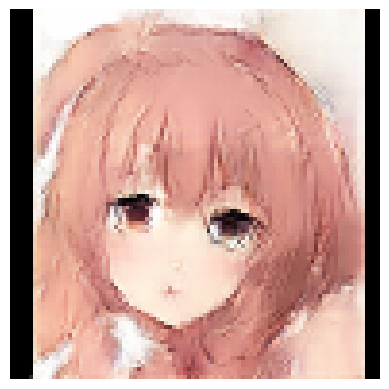

In [ ]:
#Generate Test
generate_img_step("test", False)

/bin/bash: line 1: mkdr: command not found


FileNotFoundError: ignored

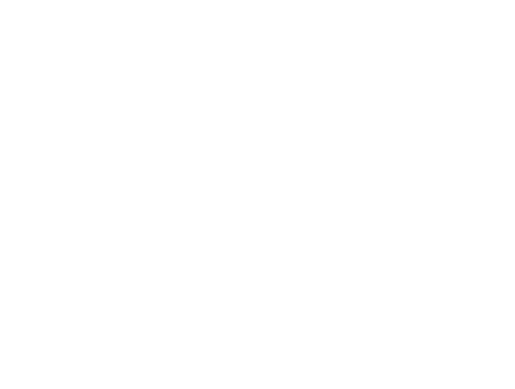

In [ ]:
gen_img(100)